In [2]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table

from astroquery.gaia import Gaia

import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

import sys

import time

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [3]:
def sample_initial_conditions(ra, de, varpi, e_varpi, pmra, e_pmra, pmde, e_pmde, corr_pmra_pmde, corr_varpi_pmra, corr_varpi_pmde, vrad, e_vrad, N_sample):

    ra_list = np.ones(N_sample) * ra # [deg]
    de_list = np.ones(N_sample) * de # [deg]

    # Mean vector
    mean = [ pmra, pmde, varpi ]

    # =========== Covariance Matrix ============ #
    cov_1 = [e_pmra**2., e_pmra * e_pmde * corr_pmra_pmde, e_pmra * e_varpi * corr_varpi_pmra]
    cov_2 = [e_pmra * e_pmde * corr_pmra_pmde, e_pmde**2., e_pmde * e_varpi * corr_varpi_pmde]
    cov_3 = [e_pmra * e_varpi * corr_varpi_pmra, e_pmde * e_varpi * corr_varpi_pmde, e_varpi**2.]
    cov = [ cov_1, cov_2, cov_3 ]

    # Drawing proper motions and parallaxes from a trivariate Gaussian distribution:
    pmra_list, pmde_list, varpi_list = np.random.multivariate_normal(mean, cov, N_sample).T # [mas/yr], [mas/yr], [mas]

    # Distance = 1 / parallax for these stars
    dist_list = 1. / (varpi_list/1.e3)  # distances, [pc]

    # Drawing radial velocities from a Gaussian distribution:
    vrad_list = np.random.normal( vrad, e_vrad, N_sample) # [km/s]

    return ra_list * u.deg, de_list * u.deg, pmra_list * u.mas/u.yr, pmde_list * u.mas/u.yr, dist_list * u.pc, vrad_list * u.km/u.s

def get_median_errors(x):

    median = np.median(x)
    lower_error = median - np.percentile(x, 16)
    upper_error = np.percentile(x, 84) - median

    return median, lower_error, upper_error

### Solar Motion Parameters

In [4]:
vSun = [14.0, 12.24, 7.25] * u.km / u.s # (U, V, W) Schonrich+12
vrot = [0., 238., 0.] * u.km / u.s # Circular rotation velocity at Sun Position, Bland-hawthorn & Gerhard 2016

RSun = 8.2 * u.kpc # Bland-hawthorn & Gerhard 2016
zSun = 25. * u.pc  # Bland-hawthorn & Gerhard 2016

v_sun = coord.CartesianDifferential(vSun + vrot)
gc = coord.Galactocentric(galcen_distance=RSun, z_sun=zSun, galcen_v_sun=v_sun)

### M31 (Andromeda) Parameters

In [5]:
ra_A = 10.6847083 * u.deg
dec_A = 41.2687500 * u.deg

dist_A = 778. * u.kpc

icrs_A = coord.ICRS(ra=ra_A, dec=dec_A, distance=dist_A)
gc_A = icrs_A.transform_to(gc)

x_A = gc_A.x
y_A = gc_A.y
z_A = gc_A.z

### Querying the Gaia Archive

In [7]:
source_id = '1552278116525348096'

job = Gaia.launch_job("SELECT * FROM gaiadr2.gaia_source WHERE source_id = " + source_id)
res = job.get_results()

ra = res['ra'][0] * u.deg
dec = res['dec'][0] * u.deg
parallax = res['parallax'][0] * u.mas
e_parallax = res['parallax_error'][0] * u.mas
pmra = res['pmra'][0] * u.mas/u.yr
e_pmra = res['pmra_error'][0] * u.mas/u.yr
pmdec = res['pmdec'][0] * u.mas/u.yr
e_pmdec = res['pmdec_error'][0] * u.mas/u.yr
vrad = res['radial_velocity'][0] * u.km/u.s
e_vrad = res['radial_velocity_error'][0] * u.km/u.s

corr_pmra_pmdec = res['pmra_pmdec_corr'][0]
corr_parallax_pmra = res['parallax_pmra_corr'][0]
corr_parallax_pmdec = res['parallax_pmdec_corr'][0]

In [8]:
#vrad = -185.124 * u.km/u.s
#e_vrad = 1.7377 * u.km/u.s

In [9]:
# Monte Carlo Sampling for the Initial conditions:

N_sample = 200

ra_list, de_list, pmra_list, pmdec_list, dist_list, vrad_list = sample_initial_conditions(ra.value, dec.value, parallax.value, e_parallax.value, pmra.value, e_pmra.value, pmdec.value, e_pmdec.value, corr_pmra_pmdec, corr_parallax_pmra, corr_parallax_pmdec, vrad.value, e_vrad.value, N_sample)

icrs_samples = coord.ICRS(ra=ra_list, dec=de_list, distance=dist_list, pm_ra_cosdec=pmra_list, pm_dec=pmdec_list, radial_velocity=vrad_list)
gc_samples = icrs_samples.transform_to(gc)

### Defining a Galactic Potential:

In [10]:
MWpotential = gp.MilkyWayPotential()

BH = gp.KeplerPotential(m=4.3e6 * u.solMass, units=galactic)

potential = MWpotential + BH

### Integrating the orbits in the Galactic Potential:

In [11]:
w0_samples = gd.PhaseSpacePosition(gc_samples.data)
orbit_samples = gp.Hamiltonian(potential).integrate_orbit(w0_samples, dt=-1*u.Myr, n_steps=1000) # 1 Gyr back in time

### Orbital Analysis

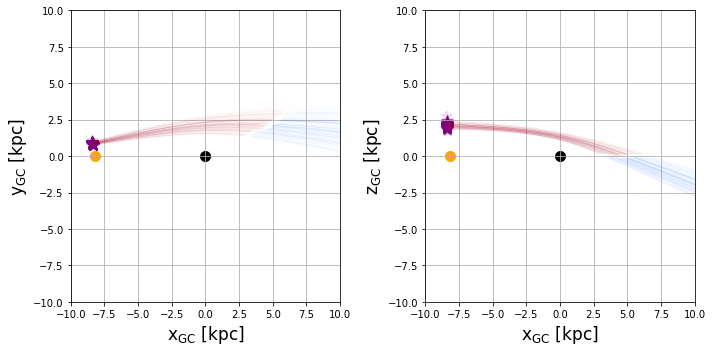

In [13]:
Xmins=np.array([])
Ymins=np.array([])
rmins=np.array([])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

circle1 = plt.Circle( (0,0), 16, color='red', fill=False)

for n in range(N_sample):
    
    orbit=orbit_samples[:,n]
    Xg = orbit.x
    Yg = orbit.y
    Zg = orbit.z
    Rg = np.sqrt( Xg**2. + Yg**2. )
    idx_cs = np.where( (np.diff(np.sign(Zg)) != 0) == True) # Check when Zg changes sign
    
    if np.size(idx_cs) != 0.:
        
        r_min = np.min(Rg[idx_cs]) # [kpc]
        tcs = orbit.t[Rg == r_min]
        Xmins = np.append(Xmins, Xg[Rg == r_min])
        Ymins = np.append(Ymins, Yg[Rg == r_min])
        rmins = np.append(rmins, r_min)
        ax1.scatter(Xg[0], Yg[0], color='purple', marker='*', s= 150, alpha=0.1)
        ax2.scatter(Xg[0], Zg[0], color='purple', marker='*', s= 150, alpha=0.1)
        ax1.plot(Xg[orbit.t >= tcs], Yg[orbit.t >= tcs], lw=0.1, linestyle='-', color='crimson', alpha=0.1)
        ax1.plot(Xg[orbit.t < tcs], Yg[orbit.t < tcs], lw=0.1, linestyle='-', color='dodgerblue', alpha=0.1)
        ax2.plot(Xg[orbit.t >= tcs], Zg[orbit.t >= tcs], lw=0.1, linestyle='-', color='crimson', alpha=0.1)
        ax2.plot(Xg[orbit.t < tcs], Zg[orbit.t < tcs], lw=0.1, linestyle='-', color='dodgerblue', alpha=0.1)
        
ax1.scatter(0., 0., color='black', s = 100)
ax1.scatter(-8.2, 0., color='orange', s = 100)

ax2.scatter(0., 0., color='black', s = 100)
ax2.scatter(-8.2, 0.025, color='orange', s = 100)

ax1.add_artist(circle1)

ax1.scatter(x_A, y_A, color='green', s = 100)
ax2.scatter(x_A, z_A, color='green', s = 100)
ax1.grid()
ax2.grid()
ax1.set_xlim(-10, 10)
ax1.set_ylim(-10, 10)
ax2.set_xlim(-10, 10)
ax2.set_ylim(-10, 10)
ax1.set_xlabel(r'$\mathrm{x_{GC} \ [kpc]}$', fontsize=17)
ax1.set_ylabel(r'$\mathrm{y_{GC} \ [kpc]}$', fontsize=17)
ax2.set_xlabel(r'$\mathrm{x_{GC} \ [kpc]}$', fontsize=17)
ax2.set_ylabel(r'$\mathrm{z_{GC} \ [kpc]}$', fontsize=17)
plt.tight_layout()

plt.savefig('/home/tommaso/Scrivania/Gaia_Sprint_Seattle/orbits/' + source_id + '.png')

plt.show()